# 笹川真生とキタニタツヤを見分けるAI(CNN)

### Preprocessing

In [1]:
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import cv2

In [2]:
# 画像ファイルのパスを取得
path_mao = glob.glob("../input/img-maokitani/img_mao/*.jpg")
# 読み込んだ画像の枚数を確認
print(len(path_mao))

150


In [3]:
path_kitani = glob.glob("../input/img-maokitani/img_kitani/*.jpg")
print(len(path_kitani))

100


In [4]:
# 画像を100x100で表示する関数を定義
def display(path):
    img = cv2.imread(path)
    # BGRで読み込まれているのでRGBに直す
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (100,100))    # 100x100にresize
    
    plt.imshow(img)
    plt.show()

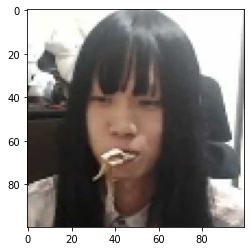

In [5]:
display(path_mao[50])

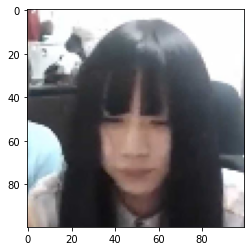

In [6]:
display(path_mao[20])

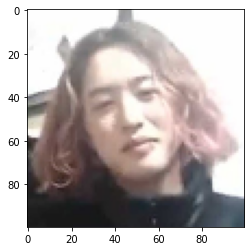

In [7]:
display(path_kitani[0])

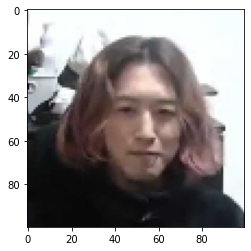

In [8]:
display(path_kitani[4])

### Data Augmentation

In [9]:
# データを格納するリスト
mao = []

center = (50,50)    # 回転の中心を指定
angles = list(range(-10, 11, 1))    # -10~10度の回転
size = (100, 100)    # 画像サイズを指定

for path in path_mao:
    
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    
    for a in angles:
        # 各角度ずつ回転させた画像を作成
        # 回転によって出てくる黒色の背景をなくすために1.15倍に拡大
        trans = cv2.getRotationMatrix2D(center, a, 1.15)
        img_rotate = cv2.warpAffine(img, trans, size)
        mao.append(img_rotate)

In [10]:
# 150枚 x 21の角度 = 3150枚
np.array(mao).shape

(3150, 100, 100, 3)

In [11]:
kitani = []

for path in path_kitani:
    
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    
    for a in angles:
        trans = cv2.getRotationMatrix2D(center, a, 1.15)
        img_rotate = cv2.warpAffine(img, trans, size)
        kitani.append(img_rotate)

In [12]:
# 100枚 x 21の角度 = 2100枚
np.array(kitani).shape

(2100, 100, 100, 3)

In [13]:
mao = np.array(mao)
kitani = np.array(kitani)

X = np.vstack([mao, kitani])
print(X.shape)

(5250, 100, 100, 3)


In [14]:
# mao, kitaniの正解ラベルをそれぞれ1, 0にする
y_mao = np.ones(len(mao))
y_kitani = np.zeros(len(kitani))

y = np.concatenate([y_mao, y_kitani])
print(y.shape)

(5250,)


# CNN実装

In [15]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras import Sequential, layers
from keras.callbacks import EarlyStopping

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=93)

print(X_train.shape)
print(X_val.shape)

(4200, 100, 100, 3)
(1050, 100, 100, 3)


In [17]:
# scaling
X_train_scaled = X_train / 255
X_val_scaled = X_val / 255

# one-hot labeling
y_train_cat = np_utils.to_categorical(y_train)
y_val_cat = np_utils.to_categorical(y_val)

In [18]:
model = Sequential()

model.add(layers.Conv2D(16, kernel_size=(4,4), strides=(1,1), padding="same", activation="relu", input_shape=(100, 100, 3)))
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=None))
model.add(layers.Dropout(0.0625))
model.add(layers.Conv2D(16, kernel_size=(4,4), strides=(1,1), padding="same", activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=None))
model.add(layers.Dropout(0.0625))
model.add(layers.Conv2D(8, kernel_size=(4,4), strides=(1,1), padding="same", activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(5,5), strides=None))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(2, activation="softmax"))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      784       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 16)        4112      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 8)         2

In [19]:
callbacks = [EarlyStopping(monitor="val_accuracy", patience=5)]

his = model.fit(x=X_train_scaled,
                y=y_train_cat,
                epochs=1000,
                batch_size=128,
                verbose=1,
                callbacks=callbacks,
                validation_data=(X_val_scaled, y_val_cat))

Epoch 1/1000
33/33 [==============================] - 24s 715ms/step - loss: 0.3858 - accuracy: 0.7974 - val_loss: 0.2668 - val_accuracy: 0.8838
Epoch 2/1000
33/33 [==============================] - 22s 669ms/step - loss: 0.0710 - accuracy: 0.9745 - val_loss: 0.0414 - val_accuracy: 0.9857
Epoch 3/1000
33/33 [==============================] - 23s 688ms/step - loss: 0.0278 - accuracy: 0.9914 - val_loss: 0.0340 - val_accuracy: 0.9895
Epoch 4/1000
33/33 [==============================] - 23s 699ms/step - loss: 0.0131 - accuracy: 0.9967 - val_loss: 0.0101 - val_accuracy: 0.9990
Epoch 5/1000
33/33 [==============================] - 22s 671ms/step - loss: 0.0081 - accuracy: 0.9983 - val_loss: 0.0138 - val_accuracy: 0.9981
Epoch 6/1000
33/33 [==============================] - 23s 690ms/step - loss: 0.0050 - accuracy: 0.9988 - val_loss: 0.0076 - val_accuracy: 1.0000
Epoch 7/1000
33/33 [==============================] - 22s 681ms/step - loss: 0.0024 - accuracy: 0.9998 - val_loss: 0.0142 - val_ac

## Judgement

In [20]:
def judge(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (100,100))
    plt.imshow(img)
    plt.show()
    
    img = img.reshape(1, 100, 100, 3)
    img_scaled = img / 255
    
    pred = model.predict(img_scaled)    # 予測
    result = np.argmax(pred)    # 0or1に変換
    
    # 1=mao, 0=kitani
    if result==1:
        print("写っているのは笹川真生")
    else:
        print("写っているのはキタニタツヤ")

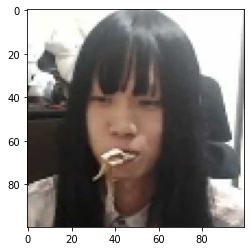

写っているのは笹川真生


In [21]:
judge(path_mao[50])

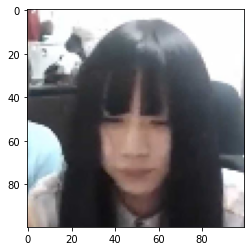

写っているのは笹川真生


In [22]:
judge(path_mao[20])

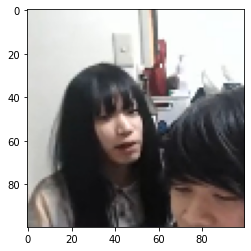

写っているのは笹川真生


In [23]:
judge(path_mao[8])

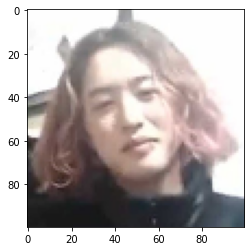

写っているのはキタニタツヤ


In [24]:
judge(path_kitani[0])

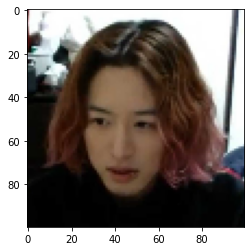

写っているのはキタニタツヤ


In [25]:
judge(path_kitani[50])

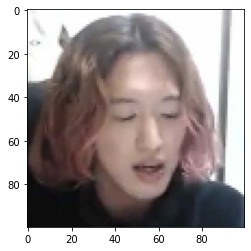

写っているのはキタニタツヤ


In [26]:
judge(path_kitani[60])

==================================================================  
結果  
少ない画像数、適当に構成したモデル、少ないエポック数でほぼ完璧な判別ができている。  
→ AI(CNN)にとって真生とキタニを見分けるのは簡単？  